<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [113]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, auc, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from matplotlib import pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Area under ROC score on train dataset: 88.17%


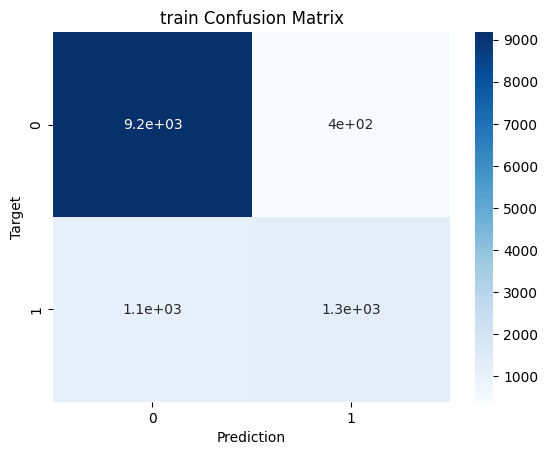

Area under ROC score on validation dataset: 88.27%


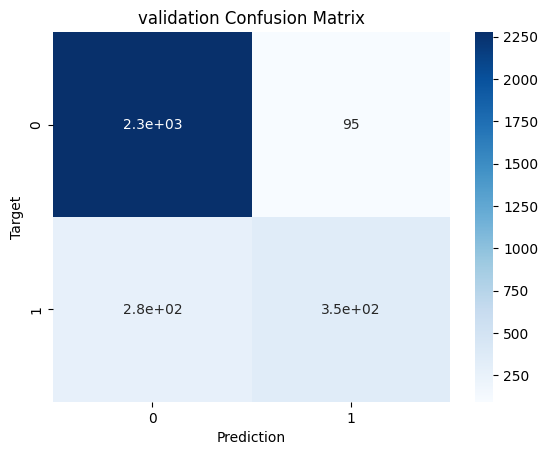

['drive/MyDrive/ML_course/model_pipeline.joblib']

In [114]:
raw_df = pd.read_csv('drive/MyDrive/ML_course/train.csv', index_col=0)
raw_df.drop(['Surname', 'CustomerId'], axis=1, inplace=True)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[0:-1]
target_col = list(raw_df.columns)[-1]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = raw_df[input_cols].select_dtypes(exclude='object').columns.tolist()
categorical_cols = raw_df[input_cols].select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler',  MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear',  penalty='l1'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    pred_proba=model_pipeline.predict_proba(inputs)[:,1]
    fpr, tpr, thresholds=roc_curve(targets, pred_proba)
    roc_auc = auc(fpr, tpr)*100
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'drive/MyDrive/ML_course/model_pipeline.joblib' )


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [115]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=2))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_feat', poly_features, numeric_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear',  penalty='l1'))
])


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Area under ROC score on train dataset dataset: 93.18%


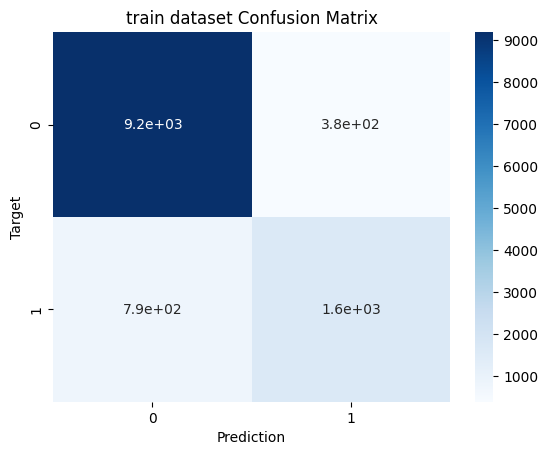

Area under ROC score on validation dataset dataset: 92.11%


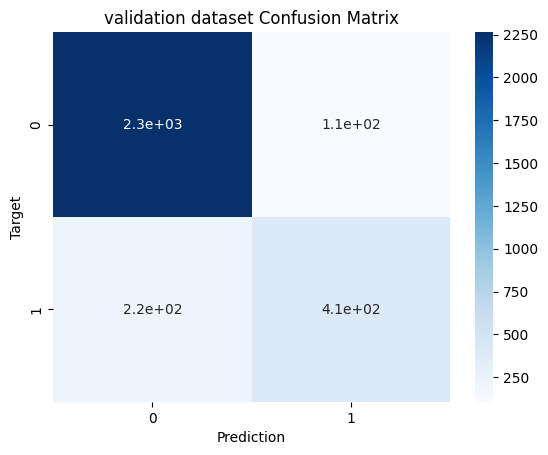

In [116]:
model_pipeline.fit(train_inputs, train_targets)
train_preds2 = predict_and_plot(model_pipeline, train_inputs, train_targets, name='train dataset')
val_preds2 = predict_and_plot(model_pipeline, val_inputs, val_targets, name='validation dataset')

In [117]:
train_preds2

array([1., 1., 0., ..., 0., 0., 1.])

In [118]:
val_preds2

array([0., 1., 0., ..., 0., 0., 1.])

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [119]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=4))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_feat', poly_features, numeric_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))
])

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Area under ROC score on train dataset dataset: 94.19%


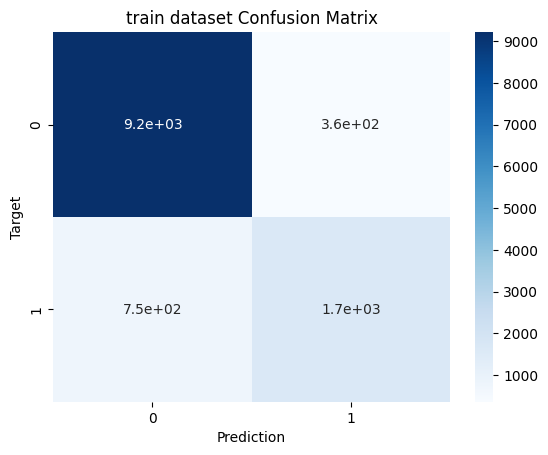

Area under ROC score on validation dataset dataset: 91.89%


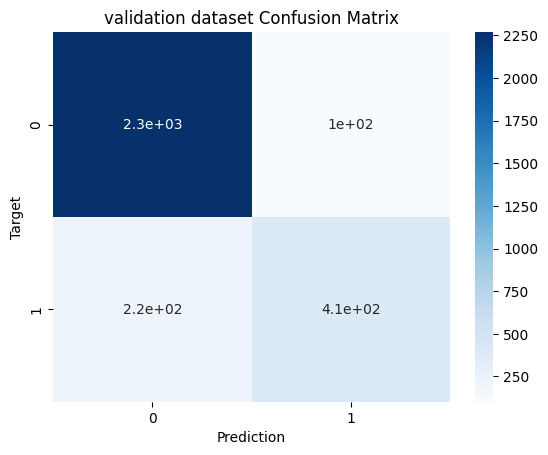

In [120]:
model_pipeline.fit(train_inputs, train_targets)
train_preds4 = predict_and_plot(model_pipeline, train_inputs, train_targets, name='train dataset')
val_preds4 = predict_and_plot(model_pipeline, val_inputs, val_targets, name='validation dataset')

In [121]:
train_preds4

array([0., 1., 0., ..., 0., 0., 1.])

In [122]:
val_preds4

array([0., 1., 0., ..., 0., 0., 1.])

In [123]:
model_pipeline.named_steps['classifier'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [124]:
regression_data = pd.read_csv('drive/MyDrive/ML_course/regression_data.csv')

In [125]:
inputs=regression_data.iloc[:,:-1]
target=regression_data.target

In [126]:
train_input, test_input, train_target, test_target=train_test_split(inputs, target, test_size=0.2, random_state=42 )

In [127]:
cols=list(inputs.columns)

poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=5))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_feat', poly_features, cols),
        ('num', numeric_transformer, cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

In [128]:
model_pipeline.fit(train_input, train_target)
train_pred_lr = model_pipeline.predict(train_input)
test_pred_lr = model_pipeline.predict(test_input)

In [129]:
train_input

,feature_1,feature_2,feature_3,feature_4,feature_5
70,0.791663,0.628346,0.624120,-1.214189,1.158111
78,0.311250,1.119575,3.078881,-0.249036,0.576557
47,0.871125,1.201214,-0.326024,0.289775,2.075401
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246
12,-0.653329,0.404982,1.765454,-0.334501,-0.474945
...,...,...,...,...,...
106,-0.248964,0.645376,0.971571,2.060748,1.755341
14,-0.342715,-0.161286,-0.802277,-1.415371,-0.420645
92,0.214094,0.173181,-1.245739,-0.446515,0.856399
51,-0.236819,0.081874,-0.485364,0.758969,-0.772825


In [130]:
root_mean_squared_error(train_target, train_pred_lr), root_mean_squared_error(test_target, test_pred_lr)

(3.049385266417107e-13, 17.032556087823863)

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [131]:
cols=list(inputs.columns)

poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=20))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_feat', poly_features, cols),
        ('num', numeric_transformer, cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', Ridge())
])

In [132]:
model_pipeline.fit(train_input, train_target)
train_pred_ridge = model_pipeline.predict(train_input)
test_pred_ridge = model_pipeline.predict(test_input)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [133]:
root_mean_squared_error(train_target, train_pred_ridge), root_mean_squared_error(test_target, test_pred_ridge)

(32.637934742750176, 8858.19170947688)

In [134]:
rmse=[]
def pipeline_lasso(degree):
  for i in range(5,degree):
      cols=list(inputs.columns)
      poly_features = Pipeline(steps=[
        ('poly_feat', PolynomialFeatures(degree=i))
    ])
      numeric_transformer = Pipeline(steps=[
        ('scaler',  StandardScaler())
    ])

      preprocessor = ColumnTransformer(
        transformers=[
            ('poly_feat', poly_features, cols),
            ('num', numeric_transformer, cols)
        ])

      model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regression', Lasso())
    ])
      model_pipeline.fit(train_input, train_target)
      train_pred_lasso = model_pipeline.predict(train_input)
      test_pred_lasso = model_pipeline.predict(test_input)
      rmse.append([i, root_mean_squared_error(train_target, train_pred_lasso), root_mean_squared_error(test_target, test_pred_lasso)])
  return rmse

In [135]:
a=pipeline_lasso(20)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+03, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.692e+03, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e+03, tolerance: 2.006e

In [136]:
a

[[5, 1.7445107548179268, 2.2752583090056397],
 [6, 1.7431698660204644, 2.15986371227158],
 [7, 1.805988054401485, 7.5078185093918295],
 [8, 1.8433610702849421, 8.016330413655892],
 [9, 1.909740711462684, 19.564662306265703],
 [10, 1.9330880047170265, 29.190970331452746],
 [11, 1.9815024057400488, 36.91348377938573],
 [12, 2.0209150153362474, 62.1863176761441],
 [13, 2.038198314884387, 64.70640316344124],
 [14, 2.0469338946340847, 75.69651875758966],
 [15, 2.05138183017231, 72.48009557859247],
 [16, 2.0535986104062887, 77.94861967558933],
 [17, 2.057187605820796, 110.28819807566492],
 [18, 2.0555170497136928, 88.4713514890799],
 [19, 2.0599613573756734, 140.73590610752098]]

In [137]:
cols=list(inputs.columns)
poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=2))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  StandardScaler())
])

preprocessor = ColumnTransformer(
transformers=[
        ('poly_feat', poly_features, cols),
         ('num', numeric_transformer, cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', Lasso(max_iter=15000))
])
model_pipeline.fit(train_input, train_target)
train_pred_lasso = model_pipeline.predict(train_input)
test_pred_lasso = model_pipeline.predict(test_input)

In [138]:
pd.DataFrame(model_pipeline.named_steps['preprocessor'].transform(train_input))

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.791663,0.628346,0.624120,-1.214189,1.158111,0.626730,0.497438,0.494092,-0.961228,...,-0.757799,0.722800,1.474254,-1.406165,1.341221,0.891659,0.521174,0.520348,-1.228460,1.099903
1,1.0,0.311250,1.119575,3.078881,-0.249036,0.576557,0.096877,0.348468,0.958302,-0.077513,...,-0.766752,1.775150,0.062019,-0.143583,0.332418,0.369802,0.969049,3.065161,-0.136425,0.520280
2,1.0,0.871125,1.201214,-0.326024,0.289775,2.075401,0.758858,1.046407,-0.284007,0.252430,...,-0.094473,-0.676629,0.083969,0.601399,4.307288,0.977976,1.043483,-0.464651,0.473221,2.014147
3,1.0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,0.036229,0.263200,0.166664,-0.102575,...,-0.471879,0.908232,0.290424,-0.558982,1.075880,-0.175059,-1.312472,-1.034407,0.755108,-1.088165
4,1.0,-0.653329,0.404982,1.765454,-0.334501,-0.474945,0.426839,-0.264586,-1.153423,0.218539,...,-0.590547,-0.838494,0.111891,0.158870,0.225573,-0.677992,0.317524,1.703552,-0.233125,-0.527731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1.0,-0.248964,0.645376,0.971571,2.060748,1.755341,0.061983,-0.160675,-0.241886,-0.513052,...,2.002163,1.705438,4.246682,3.617315,3.081221,-0.238742,0.536702,0.880546,2.477014,1.695150
99,1.0,-0.342715,-0.161286,-0.802277,-1.415371,-0.420645,0.117453,0.055275,0.274952,0.485068,...,1.135520,0.337474,2.003274,0.595369,0.176942,-0.340580,-0.198766,-0.958375,-1.456091,-0.473611
100,1.0,0.214094,0.173181,-1.245739,-0.446515,0.856399,0.045836,0.037077,-0.266705,-0.095596,...,0.556241,-1.066849,0.199376,-0.382395,0.733419,0.264264,0.106182,-1.418105,-0.359865,0.799193
101,1.0,-0.236819,0.081874,-0.485364,0.758969,-0.772825,0.056083,-0.019389,0.114943,-0.179738,...,-0.368376,0.375101,0.576034,-0.586551,0.597259,-0.225549,0.022933,-0.629836,1.004097,-0.824622


In [139]:
dict(zip(model_pipeline.named_steps['preprocessor'].get_feature_names_out(), model_pipeline.named_steps['regression'].coef_))

{'poly_feat__1': 0.0,
 'poly_feat__feature_1': 0.0,
 'poly_feat__feature_2': -0.0,
 'poly_feat__feature_3': -0.0,
 'poly_feat__feature_4': 0.0,
 'poly_feat__feature_5': -0.0,
 'poly_feat__feature_1^2': -0.0,
 'poly_feat__feature_1 feature_2': -0.0,
 'poly_feat__feature_1 feature_3': 0.0,
 'poly_feat__feature_1 feature_4': -0.0,
 'poly_feat__feature_1 feature_5': 0.0,
 'poly_feat__feature_2^2': 0.0,
 'poly_feat__feature_2 feature_3': -0.0,
 'poly_feat__feature_2 feature_4': -0.0,
 'poly_feat__feature_2 feature_5': 0.0,
 'poly_feat__feature_3^2': -0.0,
 'poly_feat__feature_3 feature_4': 0.0,
 'poly_feat__feature_3 feature_5': 0.0,
 'poly_feat__feature_4^2': -0.0,
 'poly_feat__feature_4 feature_5': -0.0,
 'poly_feat__feature_5^2': 0.0,
 'num__feature_1': 0.0,
 'num__feature_2': -0.0,
 'num__feature_3': -0.0,
 'num__feature_4': 43.12075302368195,
 'num__feature_5': -0.0}

In [140]:
root_mean_squared_error(train_target, train_pred_lasso), root_mean_squared_error(test_target, test_pred_lasso)

(1.4793687294509072, 1.3921276307730146)

In [145]:
cols=list(inputs.columns)
poly_features = Pipeline(steps=[
    ('poly_feat', PolynomialFeatures(degree=20))
])
numeric_transformer = Pipeline(steps=[
    ('scaler',  StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_feat', poly_features, cols),
        ('num', numeric_transformer, cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', ElasticNet(max_iter=10000))])

In [146]:
model_pipeline.fit(train_input, train_target)
train_pred_en = model_pipeline.predict(train_input)
test_pred_en = model_pipeline.predict(test_input)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.352e+03, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


In [147]:
root_mean_squared_error(train_target, train_pred_en), root_mean_squared_error(test_target, test_pred_en)

(8.88782867870106, 3561.2730610495205)

In [144]:
model_pipeline.named_steps['regression'].coef_.shape

(257,)